# Noise plus sine wave fitting fun

Example notebook to look at how well we can fit sine wave data that is obscured by band-limited noise.

In [1]:
from PyPurityTools import PyPurityTools as ppt
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt

# Import the curve_fit function
from scipy.optimize import curve_fit

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

In [2]:
noisePlusSineList,timeList=ppt.getScopeWaveforms("/Users/rjn/qtnm/data/noisePlusSine/npSine_450MHz_200mV_40dBatten.ch1.traces",True)
justSineList,_=ppt.getScopeWaveforms("/Users/rjn/qtnm/data/noisePlusSine/npSine_450MHz_200mV_40dBatten.ch3.traces",True)
dt=timeList[1]-timeList[0]
fs=1./dt

print(dt,timeList[-1]-timeList[0])
print(timeList.shape)

0.0001000000013351432 0.10010000133647834
(1002,)


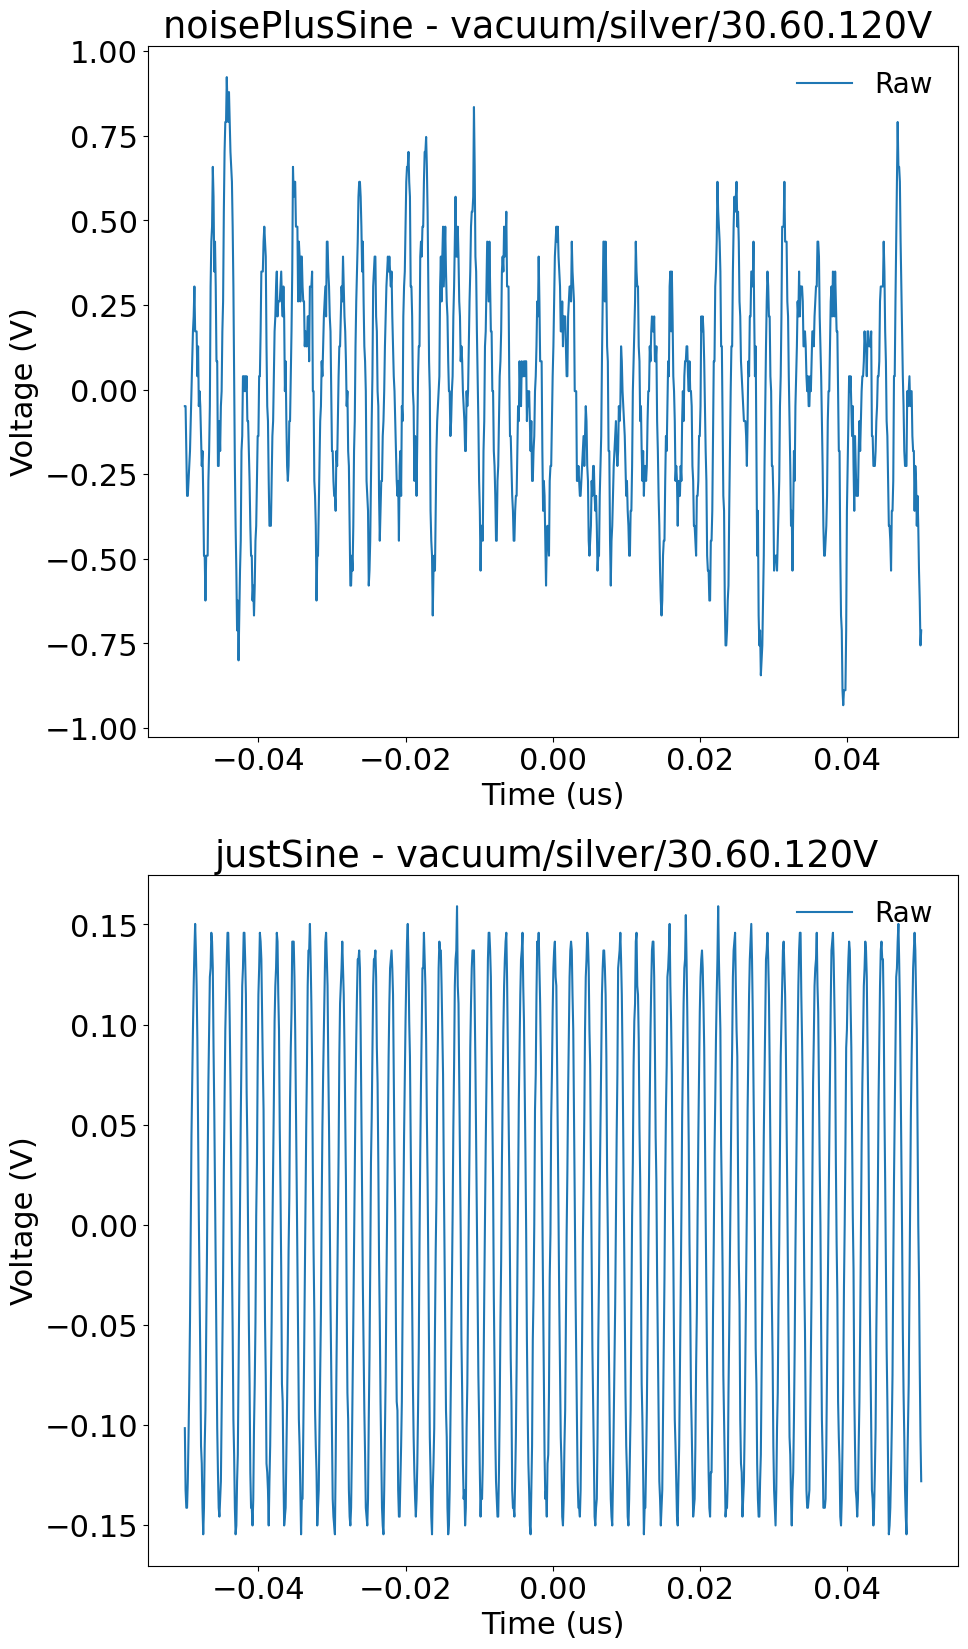

In [3]:
#smoothCat1=savgol_filter(noisePlusSineList[0], 101, 3) # window size 101, polynomial order 3
#smoothAn1=savgol_filter(justSineList[0], 101, 3) # window size 101, polynomial order 3
#lowCat=ppt.butter_lowpass_filter(noisePlusSineList[0],0.5,fs,2)  #Since fs in MHz cut off frequency needs to match
#lowAn=ppt.butter_lowpass_filter(justSineList[0],0.5,fs,2)
#lowAn2=ppt.butter_lowpass_filter(justSineList[999],0.5,fs,2)


#Plot the raw and smoothed waveforms
fig, ax = plt.subplots(2,1)
ax[0].plot(timeList,noisePlusSineList[0],label="Raw")
#ax[0].plot(timeList,smoothCat1,label="Savitzky-Golay Smoothed")
#ax[0].plot(timeList,lowCat,label="Low Pass @ 500kHz")
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('Voltage (V)')
ax[0].set_title('noisePlusSine - vacuum/silver/30.60.120V ')    
ax[0].legend(fontsize=20,loc='upper right')


ax[1].plot(timeList,justSineList[0],label="Raw")
#ax[1].plot(timeList,smoothAn1,label="Savitzky-Golay Smoothed")
#ax[1].plot(timeList,lowAn,label="Low Pass @ 500kHz")
#ax[1].plot(timeList,lowAn2,label="Low Pass @ 500kHz")
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('Voltage (V)')
ax[1].set_title('justSine - vacuum/silver/30.60.120V ')
ax[1].legend(fontsize=20,loc='upper right')
plt.subplots_adjust(bottom=0.1, right=0.8, top=2)

In [4]:
def convertToMag(yf):
    """Function to convert the result of an fft to magnitude

    Args:
        yf: The array of complex numbers from the fft (this will be both the positive and negative frequencies)
 
     Returns:
        The array of magnitudes (of length N/2) where N is the length of yf

    """
    N=yf.shape[0] #The length of yf
    return 2.0/N * np.abs(yf[0:N//2])  # The 2/N is a normalisation

N=np.shape(noisePlusSineList[0])[0]
dt=timeList[1]-timeList[0]

from scipy.fft import fft, ifft  # Import the fft and inverse fft functions
yNPS = fft(noisePlusSineList[0]) #FFT of noise plus sine
yJS = fft(justSineList[0]) #FFT of just sine
df=1/(N*dt)  # Frequency spacing
xf = np.linspace(0.0, 1.0/(2.0*dt), N//2)  #The N/2 frequency values from 0 to 1/(2*dt)

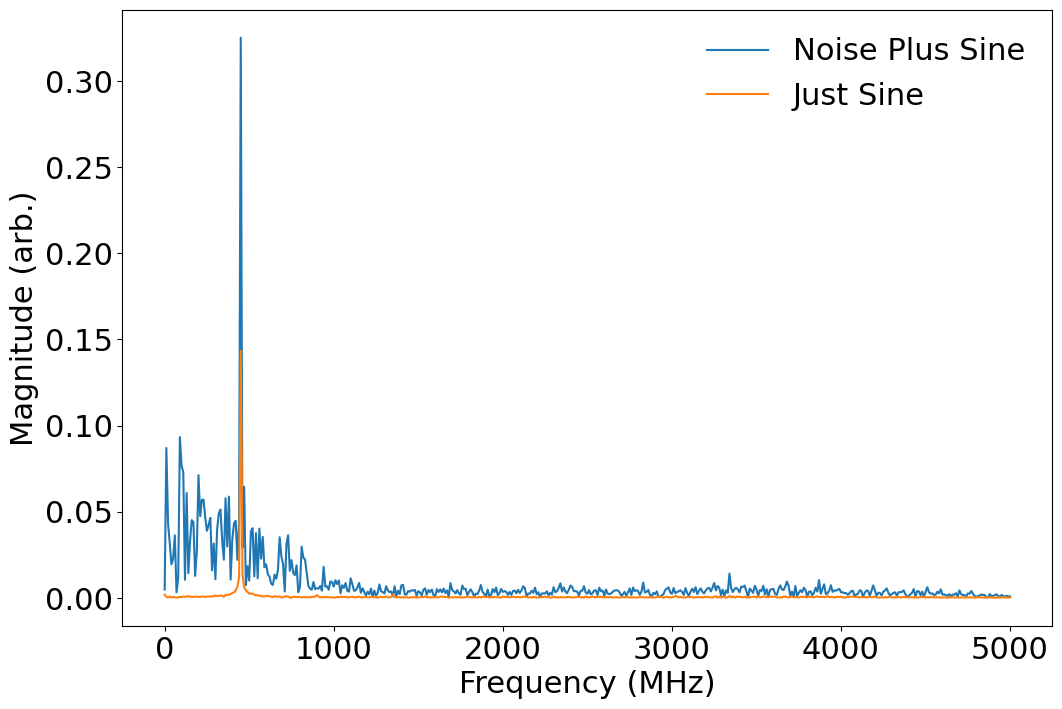

In [5]:
#Plot the frequency around the centre frequency bin
fig,ax = plt.subplots()
ax.plot(xf,convertToMag(yNPS),label="Noise Plus Sine") #1e6 to convert to MHz
ax.plot(xf,convertToMag(yJS),label="Just Sine")  #1e6 to convert to MHz
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Magnitude (arb.)")
ax.legend()

(1000, 1002)
(1002,)


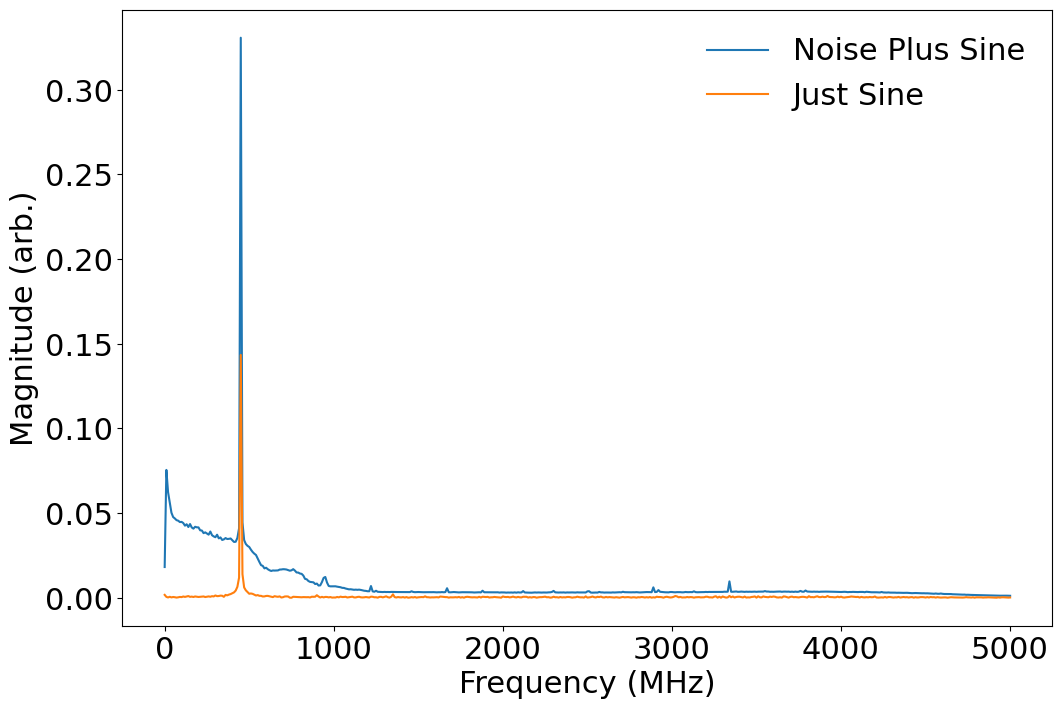

In [6]:
yNPS = fft(noisePlusSineList) #FFT of noise plus sine
print(yNPS.shape)

yNPSMean=np.mean(np.abs(yNPS),axis=0)
print(yNPSMean.shape)

fig,ax = plt.subplots()
ax.plot(xf,convertToMag(yNPSMean),label="Noise Plus Sine") #1e6 to convert to MHz
ax.plot(xf,convertToMag(yJS),label="Just Sine")  #1e6 to convert to MHz
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Magnitude (arb.)")
ax.legend()

In [7]:
def getSine(t,w,A,phi):
    """Function to return a simple sine 

    Args:
        t: The array of times
        w: The angular frequency
        A: The amplitude
        phi: The phase at t=0
 
     Returns:
        The sine values as an array

    """
    return A*np.sin((w*t)+phi)

In [8]:
def doSineWaveFit(waveList):
    numWaveforms=waveList.shape[0]
    guessOmega=450*2*math.pi
    guessAmp=np.max(waveList[0])
    guessPhase=0

    omegas=np.zeros(numWaveforms)
    freqs=np.zeros(numWaveforms)
    amps=np.zeros(numWaveforms)
    phases=np.zeros(numWaveforms)
    failCount=0

    for i in range(numWaveforms):
        try:
            parameters, covariance = curve_fit(getSine, timeList, waveList[i],p0=[guessOmega,guessAmp,guessPhase])
        except:
            print("Failure ",failCount," to fit",i)
            failCount=failCount+1
            if(failCount>10):
                raise Exception("Sorry I've given up after failing to fit",failCount)
        omegas[i]=parameters[0]
        freqs[i]=parameters[0]/(2*math.pi)
        amps[i]=parameters[1]
        phases[i]=parameters[2]
    return omegas,freqs,amps,phases

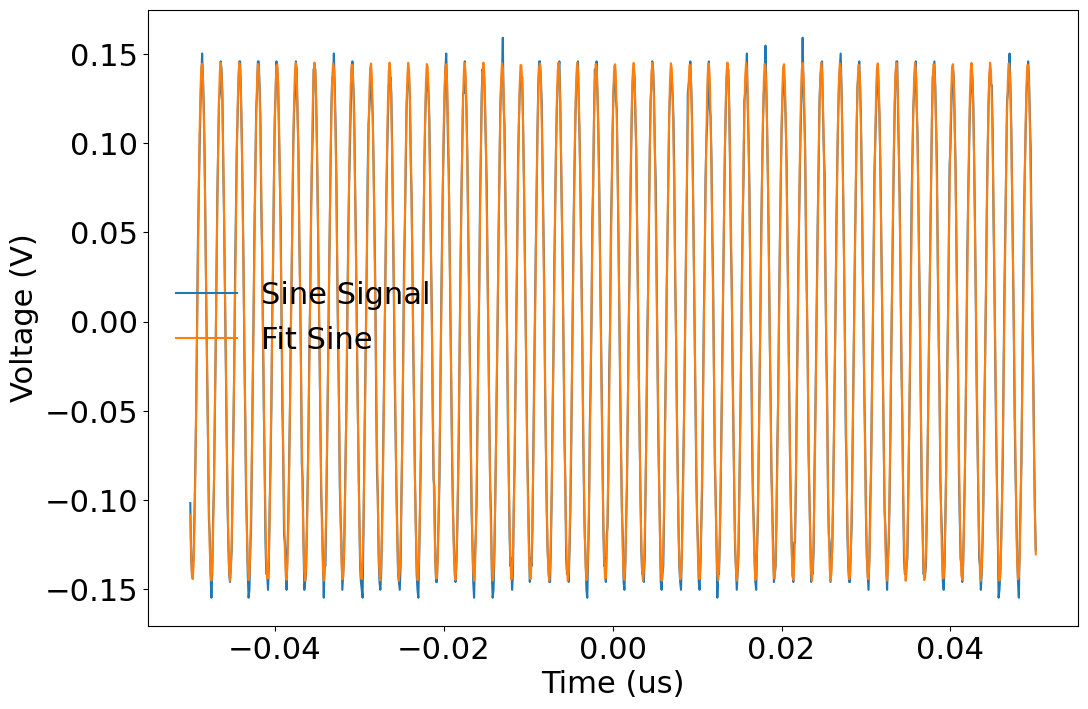

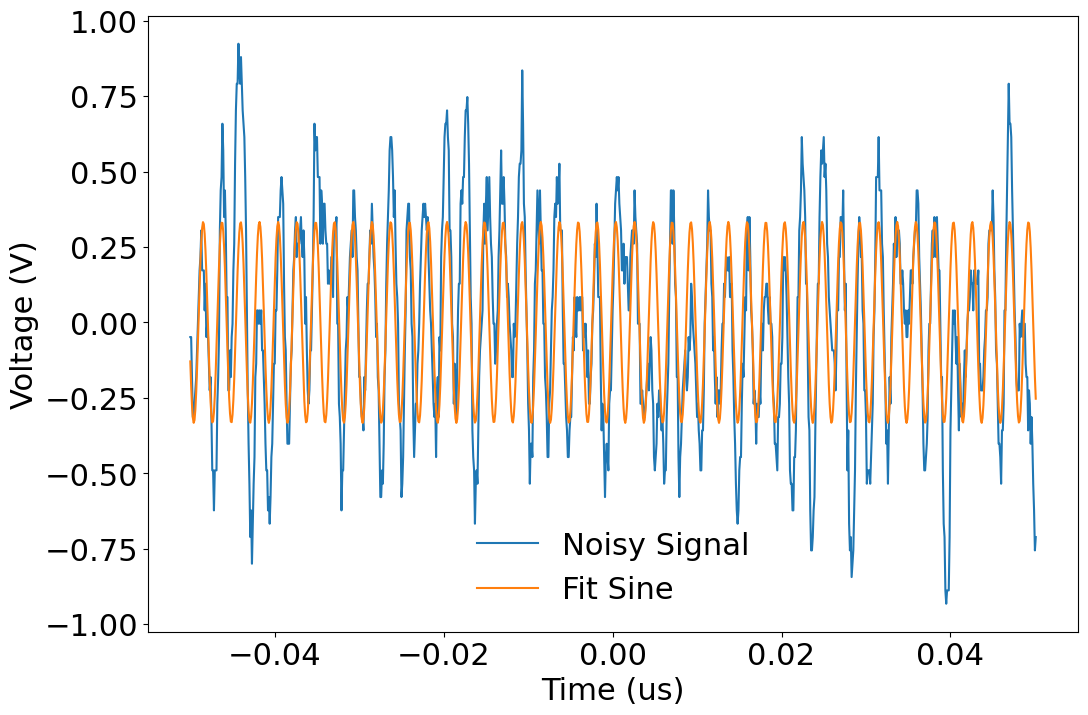

In [10]:
jsOmega,jsFreq,jsAmp,jsPhase=doSineWaveFit(justSineList)
npsOmega,npsFreq,npsAmp,npsPhase=doSineWaveFit(noisePlusSineList)


fig,ax = plt.subplots()
#ax.hist(amps,alpha=0.5,label="Sine 50MHz")
#ax.set_xlabel("Fit Frequency (Hz)")
#ax.set_ylabel("#Events")
#ax.legend()
#print("Freq std",np.std(freqs))
ax.plot(timeList,justSineList[0],label="Sine Signal")
ax.plot(timeList,getSine(timeList,jsOmega[0],jsAmp[0],jsPhase[0]),label="Fit Sine")
ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
ax.legend()

fig,ax = plt.subplots()
#ax.hist(amps,alpha=0.5,label="Sine 50MHz")
#ax.set_xlabel("Fit Frequency (Hz)")
#ax.set_ylabel("#Events")
#ax.legend()
#print("Freq std",np.std(freqs))
ax.plot(timeList,noisePlusSineList[0],label="Noisy Signal")
ax.plot(timeList,getSine(timeList,npsOmega[0],npsAmp[0],npsPhase[0]),label="Fit Sine")
ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
ax.legend()



Clean Freq std 0.010277457832663603
Noisy Freq std 0.4233777761358975


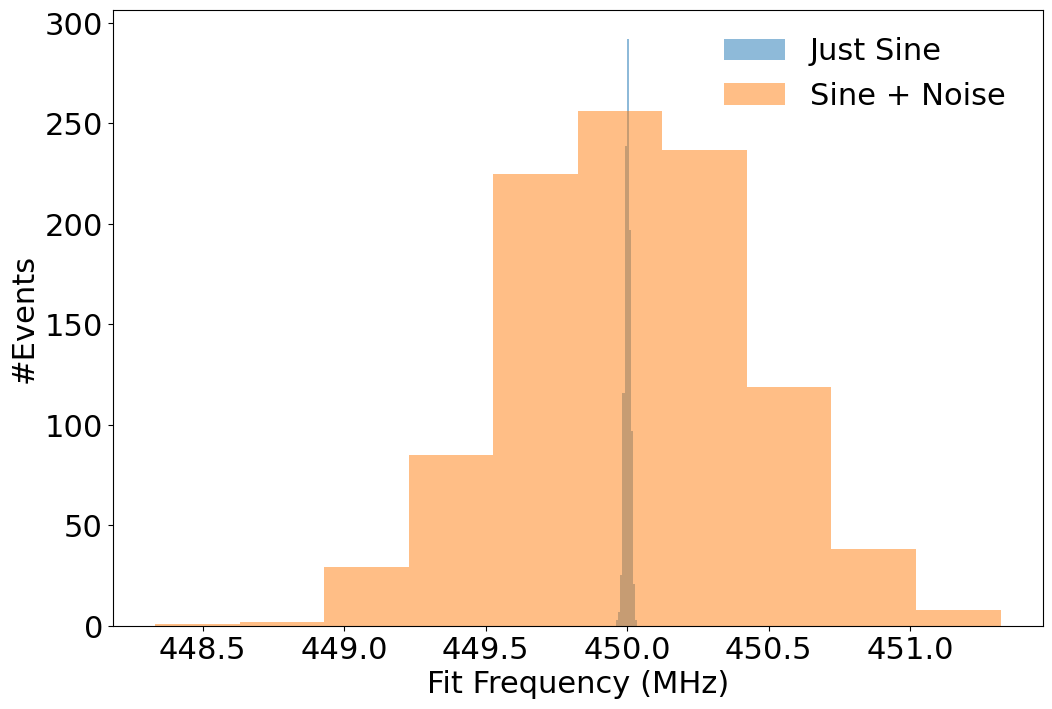

In [17]:
fig,ax = plt.subplots()
ax.hist(jsFreq,alpha=0.5,label="Just Sine")
ax.hist(npsFreq,alpha=0.5,label="Sine + Noise ")
ax.set_xlabel("Fit Frequency (MHz)")
ax.set_ylabel("#Events")
ax.legend()
print("Clean Freq std",np.std(jsFreq))
print("Noisy Freq std",np.std(npsFreq))